In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
len(os.listdir('Thermal_Project/Dataset/Train'))

300

In [5]:
len(os.listdir('Thermal_Project/Dataset/Test'))

70

In [6]:
import tensorflow as tf

tf.__version__

'2.12.0'

In [7]:

labels=pd.read_csv('Thermal_Project/Dataset/train1.csv')




In [8]:
labels.tail()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
451,20150819_183345_A.jpg,204800,{},1,0,"{""name"":""rect"",""x"":179,""y"":98,""width"":254,""hei...","{""Class"":""Cow""}"
452,20150819_183349_A.jpg,208896,{},1,0,"{""name"":""rect"",""x"":8,""y"":34,""width"":546,""heigh...","{""Class"":""Car""}"
453,20150819_183354_A.jpg,212992,{},1,0,"{""name"":""rect"",""x"":63,""y"":106,""width"":485,""hei...","{""Class"":""Car""}"
454,20150819_183403_A.jpg,208896,{},1,0,"{""name"":""rect"",""x"":79,""y"":150,""width"":404,""hei...","{""Class"":""Car""}"
455,20150819_183408_A.jpg,176128,{},1,0,"{""name"":""rect"",""x"":192,""y"":100,""width"":400,""he...","{""Class"":""Car""}"


In [9]:
labels.describe()

,file_size,region_count,region_id
count,456.00000,456.000000,456.000000
mean,179478.45614,2.002193,0.502193
std,30329.91422,1.043028,0.784461
min,77824.00000,1.000000,0.000000
25%,163840.00000,1.000000,0.000000
50%,180224.00000,2.000000,0.000000
75%,196608.00000,3.000000,1.000000
max,249856.00000,5.000000,4.000000


In [10]:
labels['region_attributes'].value_counts()

{"Class":"Person"}    220
{"Class":"Car"}       162
{"Class":"Dog"}        52
{"Class":"Cow"}        22
Name: region_attributes, dtype: int64

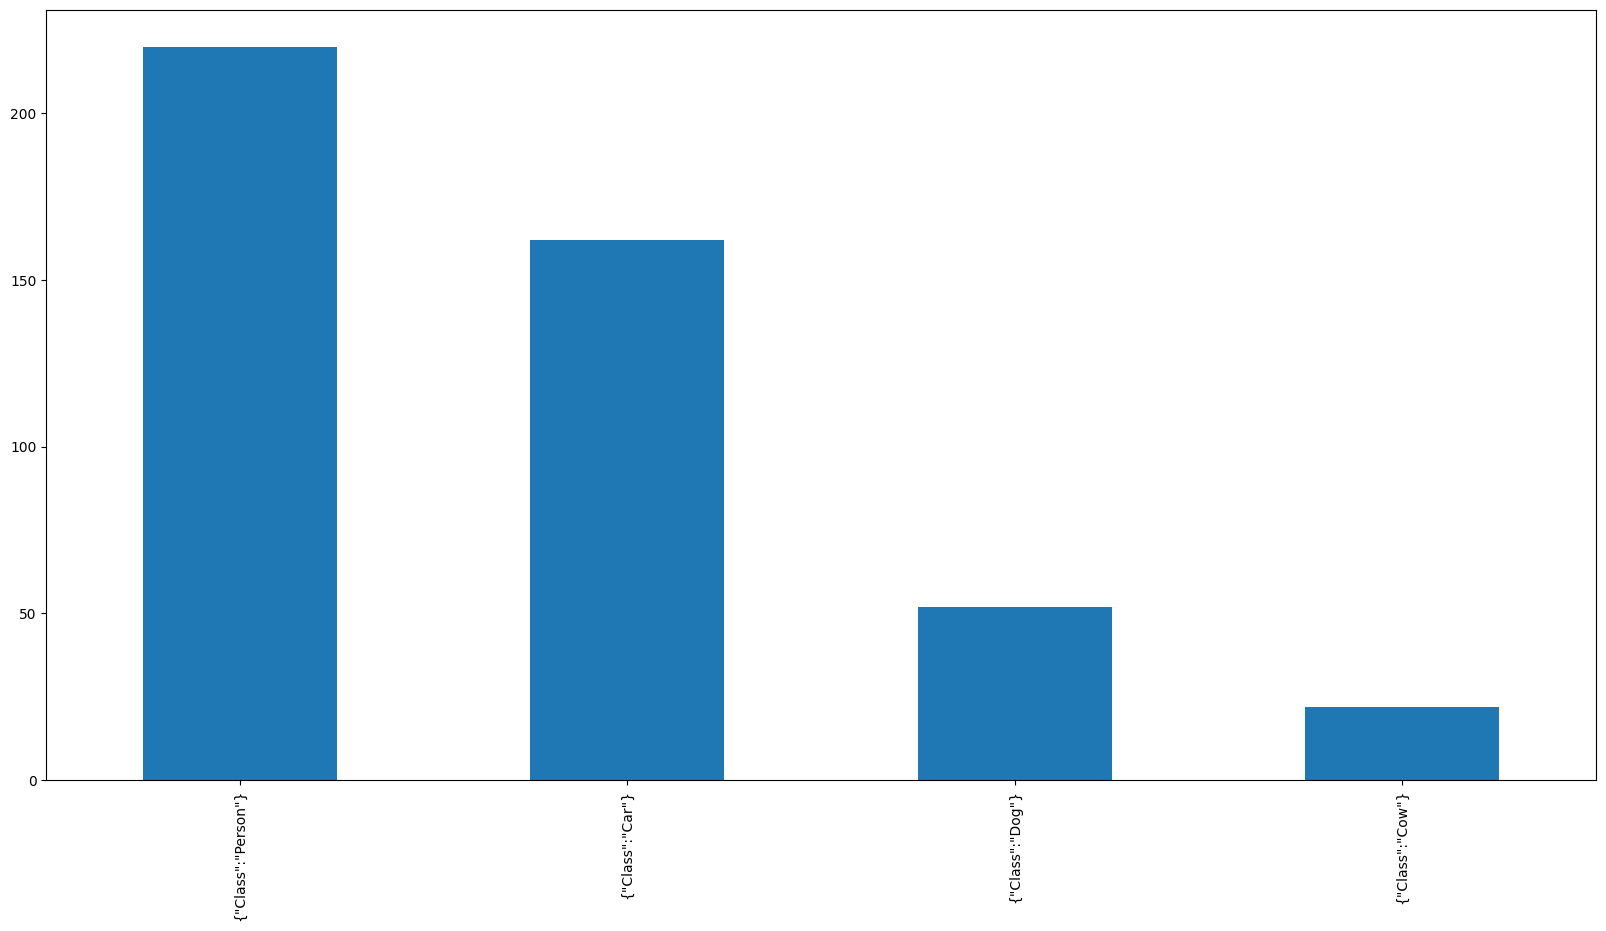

In [11]:
labels['region_attributes'].value_counts().plot(kind='bar',figsize=(20,10));

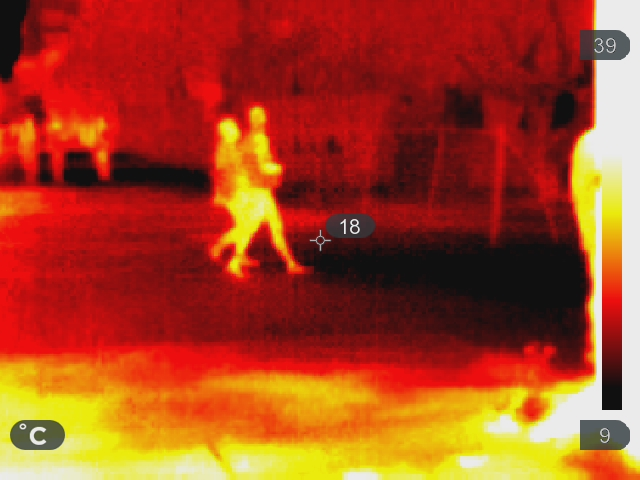

In [12]:
from IPython.display import Image
Image('Thermal_Project/Dataset/Train/20150527_090754_A.jpg')

In [13]:

#get filenames into list
import os
filepaths=[]
for i in os.listdir('Thermal_Project/Dataset/Train/'):
  filepaths.append('Thermal_Project/Dataset/Train/'+i)

In [14]:
filepaths[:5]

['/content/drive/MyDrive/new_dataset/Train/20150527_090754_A.jpg',
 '/content/drive/MyDrive/new_dataset/Train/20150527_090805_A.jpg',
 '/content/drive/MyDrive/new_dataset/Train/20150527_090816_A.jpg',
 '/content/drive/MyDrive/new_dataset/Train/20150527_090833_A.jpg',
 '/content/drive/MyDrive/new_dataset/Train/20150527_090844_A.jpg']

In [15]:
#convert thermal labels into a numpy array

thermal_labs=np.array(labels['region_attributes'])
len(thermal_labs)

456

In [16]:
unique_class=np.unique(thermal_labs)
len(unique_class)

4

In [17]:
#unique_class.class_indices

In [18]:
thermal_labs[3]==unique_class

array([ True, False, False, False])

In [19]:
#create boolean labels

boolean_labels=[]
for i in thermal_labs:
  boolean_labels.append(i==unique_class)

In [20]:
len(boolean_labels)

456

In [21]:
print(thermal_labs[4])

{"Class":"Car"}


In [22]:

print(np.where(unique_class==thermal_labs[1]))

(array([3]),)


In [23]:
boolean_labels[1].argmax()

3

In [24]:


x=filepaths
y=np.array(boolean_labels).astype('int64')


In [25]:
NUM_IMAGES= 300 #@param{type:'slider',min:50,max:300,step:300}

In [26]:
#split into training and validation sets

from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=42)

In [27]:
len(x_train),len(x_val),len(y_train),len(y_val)

(240, 60, 240, 60)

In [28]:
def preprocess(file):

  image=tf.io.read_file(file)
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,size=[224,224])
  return image
  

In [29]:
#create a function to return a tuple of image and its label

def show_image_label(im,la):

  image=preprocess(im)
  
  return image,la

In [30]:
x[:5]

['/content/drive/MyDrive/new_dataset/Train/20150527_090754_A.jpg',
 '/content/drive/MyDrive/new_dataset/Train/20150527_090805_A.jpg',
 '/content/drive/MyDrive/new_dataset/Train/20150527_090816_A.jpg',
 '/content/drive/MyDrive/new_dataset/Train/20150527_090833_A.jpg',
 '/content/drive/MyDrive/new_dataset/Train/20150527_090844_A.jpg']

In [31]:
def make_batches(x,y=None,test_data=False,valid_data=False):

  
  if valid_data:
    print('creating valid data')
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data=data.map(show_image_label)
    data=data.batch(10)
    return data

  elif test_data:
    print('creating test data')
    data=tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data=data.map(preprocess)
    data=data.batch(10)
    return data

  else:
    print('creating training data')
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data=data.shuffle(buffer_size=(len(x)))
    data=data.map(show_image_label)
    data=data.batch(10)
    return data    




In [32]:
train_data=make_batches(x=x_train,y=y_train)
valid_data=make_batches(x=x_val,y=y_val,valid_data=True)

creating training data
creating valid data


In [33]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.int64, name=None))>

In [34]:
valid_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.int64, name=None))>

In [35]:
train_data.element_spec,valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.int64, name=None)))

In [36]:
#function to visualize images
def show_5_images(images,labels):
  plt.figure(figsize=(10,10))
  for i in range(5):
    ax=plt.subplot(1,5,i+1)

    plt.imshow(images[i])

    plt.title(unique_class[labels[i].argmax()])

    plt.axis('off')

In [37]:
train_images,train_labels=next(train_data.as_numpy_iterator())


In [38]:
#check for valid data
valid_images,valid_labels=next(valid_data.as_numpy_iterator())

In [39]:
train_images.shape,train_labels.shape

((10, 224, 224, 3), (10, 4))

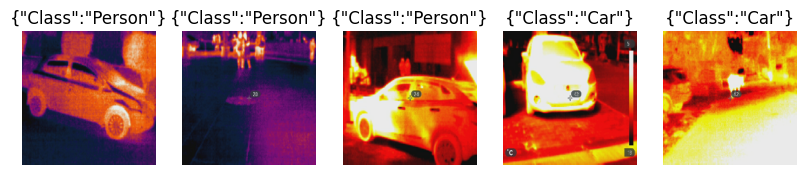

In [40]:
#show training batch
show_5_images(images=train_images,labels=train_labels)

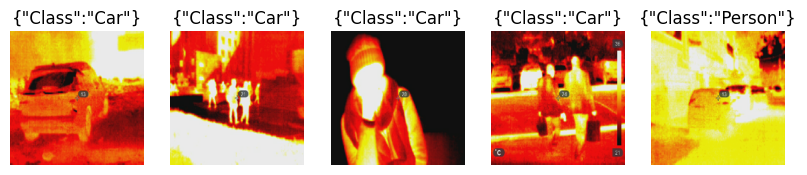

In [41]:
#show validation batch
show_5_images(images=valid_images,labels=valid_labels)

In [42]:
#set inputs and outputs
IMG_SHAPE=224

INPUT_SHAPE=[None,IMG_SHAPE,IMG_SHAPE,3]

OUTPUT_SHAPE=len(unique_class)

model='https://tfhub.dev/google/efficientnet/b0/classification/1'

In [43]:
import tensorflow_hub as hub

In [44]:
#create a model

def create_model(model_url=model,input=INPUT_SHAPE,out=OUTPUT_SHAPE):

  model=tf.keras.Sequential([hub.KerasLayer(model_url),
                             tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                             activation='softmax')])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
  
  model.build(input)

  return model
                            

In [45]:
model=create_model()


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              5330564   
                                                                 
 dense (Dense)               (None, 4)                 4004      
                                                                 
Total params: 5,334,568
Trainable params: 4,004
Non-trainable params: 5,330,564
_________________________________________________________________


In [47]:
model.save("model")

In [48]:
#create callback

from tensorflow.keras.callbacks import EarlyStopping
early=EarlyStopping(monitor='val_loss',patience=5)

In [49]:
#set number of epochs model has to train on

NUM_EPOCHS=40 #@param{type:'slider',min:10,max:100,step:10}



In [50]:
history = model.fit(train_data,epochs=NUM_EPOCHS,validation_data=valid_data,callbacks=[early])

Epoch 1/40
24/24 [==============================] - 16s 110ms/step - loss: 1.2332 - accuracy: 0.5125 - val_loss: 1.3989 - val_accuracy: 0.4333
Epoch 2/40
24/24 [==============================] - 3s 116ms/step - loss: 0.9228 - accuracy: 0.6417 - val_loss: 1.3771 - val_accuracy: 0.4167
Epoch 3/40
24/24 [==============================] - 2s 79ms/step - loss: 0.7652 - accuracy: 0.6750 - val_loss: 1.3724 - val_accuracy: 0.4500
Epoch 4/40
24/24 [==============================] - 2s 68ms/step - loss: 0.6826 - accuracy: 0.7125 - val_loss: 1.4159 - val_accuracy: 0.4500
Epoch 5/40
24/24 [==============================] - 2s 67ms/step - loss: 0.5840 - accuracy: 0.7500 - val_loss: 1.4542 - val_accuracy: 0.5000
Epoch 6/40
24/24 [==============================] - 2s 68ms/step - loss: 0.5243 - accuracy: 0.7667 - val_loss: 1.4388 - val_accuracy: 0.5167
Epoch 7/40
24/24 [==============================] - 2s 68ms/step - loss: 0.4971 - accuracy: 0.7708 - val_loss: 1.4917 - val_accuracy: 0.5167
Epoch 8/40

In [51]:
import matplotlib.pyplot as plt

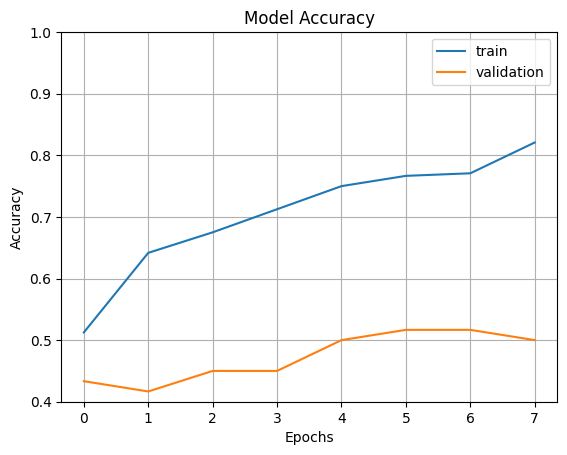

In [52]:
fig1 = plt.gcf()
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

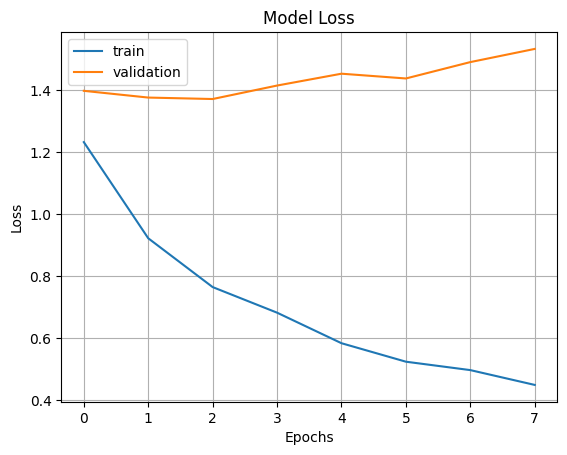

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()





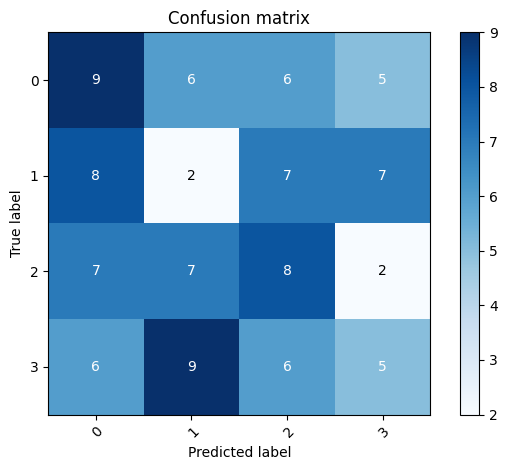

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate some example data
y_true = np.random.randint(0, 4, size=100)
y_pred = np.random.randint(0, 4, size=100)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=np.arange(4),
       yticklabels=np.arange(4),
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()


In [55]:
pred_list = [f"/content/drive/MyDrive/machine_model/Data/val/{i}" for i in os.listdir("/content/drive/MyDrive/machine_model/Data/val/")]

In [56]:
pred_list

['/content/drive/MyDrive/machine_model/Data/val/20150527_090844_A.jpg',
 '/content/drive/MyDrive/machine_model/Data/val/20150527_090847_A.jpg',
 '/content/drive/MyDrive/machine_model/Data/val/20150527_091018_A.jpg',
 '/content/drive/MyDrive/machine_model/Data/val/20150527_091952_A.jpg',
 '/content/drive/MyDrive/machine_model/Data/val/20150527_092740_A.jpg',
 '/content/drive/MyDrive/machine_model/Data/val/20150527_092828_A.jpg',
 '/content/drive/MyDrive/machine_model/Data/val/20150527_092831_A.jpg',
 '/content/drive/MyDrive/machine_model/Data/val/20150527_092849_A.jpg',
 '/content/drive/MyDrive/machine_model/Data/val/20150527_093527_A.jpg',
 '/content/drive/MyDrive/machine_model/Data/val/20150527_093532_A.jpg',
 '/content/drive/MyDrive/machine_model/Data/val/.ipynb_checkpoints']